# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner

## Import Packages Etc

In [203]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import itertools
from pandas.plotting import scatter_matrix
from collections import OrderedDict


%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [308]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
     criteria: str,'label'or'probability', default:'label'
                  used to specify whether the stacked model input is a label prediction or probability predictions of base models
        
     stack_input: bool, default:False
                     used to specify whether to add original input to the stack layer.
        
     stack_model : str, name of the model at the stack model, default:'CART'
     base_models: list, list of base models, default:['LR','KNN','CART','SVC','NB','MLP']
                     used to specify the list of base models to be used.
                     
     number_of_models: int, number of base models, default:6
                          used to specify the number of base models
        
    Methods
    ----------
     fit(X,Y) : Fit the model according to the given training data.
     
     predict(X): Predict class labels for samples in X.
     
     predict_proba: Predict class probabilities for samples in X.
     
     get_predictive_power_base_models(): to get the accuracies of the base models on the training set of the Superlearner
     
     get_confusion_matrix_base_models(): to get the confusion matrices of the base learners on the training set of the Superlearner
     
     get_diversity_base_models() :  to get the diversity among the base models in terms of correlation coefficient, Q statistics 
                                 and disagreement measure
    Attributes:
    -------------
    base_models_predictions : the list of predictions of the abse models.
    
    
   Notes
    -----
    Number of base mdoels should be between 5 to 10.
    The list of base models should be from the choice 7 base models : ['LR','KNN','CART','SVC','NB','MLP','RF']
    If a list of base models are passed then Superlearners trains the base _models with default sensible hyper parameters.
    if a dictionary of base models along with the hyper parameters are sent, it overwrites the default hyper parameters of 
    the base models.
    
    
    See also
    --------
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = SuperLearnerClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    
    # Constructor for the classifier object
    def __init__(self,criteria='label',stack_input=False, stack_model= 'CART',
                 base_models=['LR','KNN','CART','SVC','NB','MLP'], number_of_models=6):
                                                                            
        
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        criteria: str,'label'or'probability', default:'label'
                  used to specify whether the stacked model input is a label prediction or probability predictions of base models
        
        stack_input: bool, default:False
                     used to specify whether to add original input to the stack layer.
        
        base_models: list or dict, list of base models or dictionary of base models with their corresponding hyper parameters, default:['LR','KNN','CART','SVC','NB']
                     used to specify the list of base models to be used.
                     
        number_of_models: int, number of base models, default:5
                          used to specify the number of base models
        Returns
        -------
        self: Object
        """
        if criteria not in ['label','probability']:
            raise ValueError('Unknown criteria',criteria);
            return;
            
        if number_of_models < 5 or number_of_models > 10:
            raise ValueError('Number of models should be 5 to 10');
            return;
        
        if len(base_models) < 3:
            raise ValueError('Number of models should be 5 to 10');
            return;
        
        #default hyper parameter if no hyper parameter is used
        best_parameters = {'CART': {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 50}, 
                           'RF': {'max_features': 4, 'min_samples_split': 25, 'n_estimators': 200}, 
                           'KNN': {'n_neighbors': 6}, 
                           'LR': {'C': 0.2, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}, 
                           'MLP': {'alpha': 1e-05, 'hidden_layer_sizes': (400, 200), 'solver':'lbfgs', 'activation':'logistic'}, 
                           'SVC': {'probability':True},
                           'NB':{}
                          }
        
        
        self.base_models = base_models
        self.criteria = criteria
        self.stack_input = stack_input
        self.stack_model = stack_model
        self.base_models_predictions = []
          
        if(not isinstance(base_models, list)):
            # overwrite the default parameters with the parameters passed in the base_models dictionary:
            for model in self.base_models:
                best_parameters[model] = self.base_models[model];
            self.base_models = list(self.base_models.keys())
        
        self.models = []
        self.number_of_models = number_of_models;
        
        #make a dictionary of model choices
        models_choices_ = {}
        models_choices_['LR'] = LogisticRegression(**best_parameters['LR'])
        models_choices_['SVC'] = SVC(**best_parameters['SVC'])
        models_choices_['KNN'] =  KNeighborsClassifier(**best_parameters['KNN'])
        models_choices_['CART'] = DecisionTreeClassifier(**best_parameters['CART'])
        models_choices_['NB'] = GaussianNB() #no hyper parameter to tune for Naive Bayes
        models_choices_['RF'] = RandomForestClassifier(**best_parameters['RF'])
        models_choices_['MLP'] = MLPClassifier(**best_parameters['MLP'])
        
        #get the actuale base models to be used in the superlearner based on the number of models and model choices
        index = 0
        for n in range(number_of_models):
            if index == len(self.base_models):
                index = 0
            if self.base_models[index] not in models_choices_:
                raise ValueError('Bad choice of model ',self.base_models[index])
                return
            else:
                self.models.append(copy.deepcopy(models_choices_[self.base_models[index]]))
            index+=1;
            
            
        #stack layer model       
        if(self.stack_model not in models_choices_):
            raise ValueError('Bad choice of model ',self.stack_model)
            return
            
       
        self.final_stack_model = copy.deepcopy(models_choices_[self.stack_model])
       
        

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        k = 10
        each_fold_length = int(len(X)/k)
        
        # fold X and Y
        sub_samples_X=[X[i:i+each_fold_length] for i in range(0,len(X),each_fold_length)]
        sub_samples_y=[y[i:i+each_fold_length] for i in range(0,len(X),each_fold_length)]
   
        stacked_predictions = []
        for i in range(0,len(sub_samples_X)):
            # make the ith fold as test fold and remaining folds as training set
            X_test = sub_samples_X[i];
            X_train = [sub_samples_X[j] for j in range(0,len(sub_samples_X)) if j!=i]
            y_test = sub_samples_y[i];
            y_train = [sub_samples_y[j] for j in range(0,len(sub_samples_X)) if j!=i]
            
            #flatten the X_train and y_train to match the shape
            X_train = list(itertools.chain.from_iterable(X_train))
            y_train = list(itertools.chain.from_iterable(y_train))
            
            #fit the base models for the ith test_fold in k-fold
            y_pred = []
            for model in self.models:
                model.fit(X_train,y_train)
                #depending upon the criterian taking prediction label/ prediction probability from the trained base modls
                if self.criteria == 'label':
                    predicted_value = model.predict(X_test)
                else:
                    predicted_value = model.predict_proba(X_test)
                y_pred.append(predicted_value.tolist())
            
            #stack the predicted output of the base models.
            stacked_predictions.append(np.column_stack(y_pred).tolist())
            
            
        # flatten the stacked_prediction to match the shape
        stacked_predictions = list(itertools.chain.from_iterable(stacked_predictions))
        
        #base_models_predictions is stored to verify diversity among base models
        self.base_models_predictions = np.column_stack(stacked_predictions)
       
        #depending upon the parameter the original input data is stacked
        if(self.stack_input):
            stacked_predictions = np.column_stack((X,stacked_predictions))
       
        #fit the stacked model 
        self.final_stack_model.fit(stacked_predictions,y)
    
        #train the base models again with the entire training set
        for model in self.models:
                model.fit(X,y)
        #storing the y values to verify the predictive power of the base models
        self.y = y
        
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        X_predict = []
        for model in self.models:
            if self.criteria == 'probability':
                X_predict.append(model.predict_proba(X))
            else:
                X_predict.append(model.predict(X))
                
        stacked_predict = np.column_stack(X_predict).tolist()

        if(self.stack_input):
            stacked_predict = np.column_stack((X,stacked_predict))
            
       
        final_predict = self.final_stack_model.predict(stacked_predict)
        
        return final_predict
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        X_predict = []
        for model in self.models:
            if self.criteria == 'probability':
                X_predict.append(model.predict_proba(X).tolist())
            else:
                X_predict.append(model.predict(X).tolist())
        stacked_predict = np.column_stack(X_predict)
        if(self.stack_input):
            stacked_predict = np.column_stack((X,stacked_predict))
        final_predict = self.final_stack_model.predict_proba(stacked_predict)

        return final_predict
    
    """
    We want the each base model to be a strong predictor
    """
    def get_predictive_power_base_models(self):
        """ Measure the predictive power of the base_models
        Parameters
        ----------
        self : Object
        
        Returns
        -------
        predictive_power: A dictionary containing the accuracy score all the base models
        """
        predictive_power = {}
        for indx in range(len(self.base_models_predictions)):
            predictive_power[self.base_models[indx]] = metrics.accuracy_score(self.y, self.base_models_predictions[indx])
        return predictive_power
    
    def get_confusion_matrix_base_models(self):
        confusion_matrics_dict = {}
        for i in range(len(self.base_models)):
            confusion_matrics_dict[self.base_models[i]] = pd.crosstab(np.array(self.y), self.base_models_predictions[i], rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)
        return confusion_matrics_dict
    
    def get_pairwise_relation_(self,model1_predict,model2_predict):
        """ Measure the number of agreements and disagreements between two models
        Parameters
        ----------
        model1_predict , model2_predict : Number of predictions of two models
        
        Returns
        -------
        A tuple containing (N00,N01,N10,N11)
        
        """
        N00 = 0
        N01 = 0;
        N10 = 0;
        N11 = 0
        for i in range(len(model1_predict)):
            if(model1_predict[i] == y_train[i] and model2_predict[i] == y_train[i]):
                N11 +=1
            elif(model1_predict[i] == y_train[i] and model2_predict[i] != y_train[i]):
                N10 += 1
            elif(model1_predict[i] != y_train[i] and model2_predict[i] == y_train[i]):
                N01 += 1
            elif(model1_predict[i] != y_train[i] and model2_predict[i] != y_train[i]):
                N00 += 1
        return (N00,N11,N10,N01)
    
    def get_q_score_(self,N00,N11,N10,N01):
        """ Measure the Q_Statistics between two models
        Parameters
        ----------  
        NOO: Number of samples incorrectly predicted by model1 as well as model2 
        N01: Number of samples incorrectly predicted by model1, but correctly predicted by model2
        N10: Number of samples correctly predicted by model1, but incorrectly predicted by model2
        N11: Number of sample correclt predicted by both the models
        
        Returns
        -------
        q_measure : Q_statistics measure
        
        """
        q_measure = (N00*N11 - N10*N01)/(N00*N11 + N10*N01)
        return q_measure
    
    def get_corr_coef_(self,N00,N11,N10,N01):
        """ Measure the Q_Statistics between two models
        Parameters
        ----------  
        NOO: Number of samples incorrectly predicted by model1 as well as model2 
        N01: Number of samples incorrectly predicted by model1, but correctly predicted by model2
        N10: Number of samples correctly predicted by model1, but incorrectly predicted by model2
        N11: Number of sample correclt predicted by both the models
        
        Returns
        -------
        corr_coeff : Correlation Coefficient
        
        """
        corr_coeff = (N00*N11 - N10*N01)/((N11+N10)*(N01+N00)*(N11+N01)*(N10+N00))**0.5
        return corr_coeff
    
    def get_disagreement_measure_(self,N00,N11,N10,N01):
        """ Measure the Q_Statistics between two models
        Parameters
        ----------  
        NOO: Number of samples incorrectly predicted by model1 as well as model2 
        N01: Number of samples incorrectly predicted by model1, but correctly predicted by model2
        N10: Number of samples correctly predicted by model1, but incorrectly predicted by model2
        N11: Number of sample correclt predicted by both the models
        
        Returns
        -------
        dm : Disagreement measure
        
        """
        dm = (N01+N10)/(N00+N11+N10+N01)
        return dm;
    
    """
        In any ensemble (eg.Superlearner) we want the classifiers to be weakly correlated to each other.
        There are three measures are taken to find out the diversities among the model.
        
        The Q Statistics :
            The Q statistics of two binary classifier outputs (correct/incorrect), yi and yk
            Qi,k = (N11*N00 − N01*N10)/(N11*N00 + N01*N10) Classifiers that tend to recognize the same objects correctly will have positive
            values of Q, and those which commit errors on different objects will render Q negative.
        
        The correlation coefficient ρ :
            The correlation between two binary classifier outputs (correct/incorrect), yi and yk , is
            ρi,k = (N11*N00 − N01*N10)/((N11 + N10)(N01 + N00)(N11 + N01)(N10 + N00))**0.5
        
        The disagreement measure:
            It is the ratio between the number of observations on which one classifiervis correct and the other is incorrect to the total number of observations.
            Disi,k = (N01 + N10) / (N11 + N10 + N01 + N00)
            
        NOO: Number of samples incorrectly predicted by model1 as well as model2 
        N01: Number of samples incorrectly predicted by model1, but correctly predicted by model2
        N10: Number of samples correctly predicted by model1, but incorrectly predicted by model2
        N11: Number of sample correclt predicted by both the models
        
        ref : https://link.springer.com/content/pdf/10.1023%2FA%3A1022859003006.pdf
        
        """
    def get_diversity_base_models(self):
        """ Measure the diversities among all the base models taking into acount their agreement and disagreement.
        Parameters
        ----------
        self: Object
        
        Returns
        -------
        R : A tuple of dataframe containing pairwise Q_statistics, pairwise Correlation Coefficient, pairwise disagreement measure
        
        """
        corr_coef_matrix = {}
        q_stat_matrix = {}
        dm_matrix = {}
        for i in range(len(self.base_models)):
            list_of_corr_coef = []
            list_of_q_stat = []
            list_of_dm = []
            for j in range(len(self.base_models)):
                    model1 = self.base_models[i]
                    model2 = self.base_models[j]
                    model1_predictions = self.base_models_predictions[i]
                    model2_predictions = self.base_models_predictions[j]
                
                    N00, N01, N10, N11 = self.get_pairwise_relation_(model1_predictions, model2_predictions)
                    
                    # get correlation coefficient 
                    list_of_corr_coef.append(self.get_corr_coef_(N00, N01, N10, N11))
                    #get q_statistics
                    list_of_q_stat.append(self.get_q_score_(N00, N01, N10, N11))
                    #get disagreement measure
                    list_of_dm.append(self.get_disagreement_measure_(N00, N01, N10, N11))
            
            corr_coef_matrix[self.base_models[i]] = list_of_corr_coef
            q_stat_matrix[self.base_models[i]] = list_of_q_stat
            dm_matrix[self.base_models[i]] = list_of_dm
            
        return (pd.DataFrame(OrderedDict(corr_coef_matrix),index=self.base_models), \
                pd.DataFrame(OrderedDict(q_stat_matrix),index=self.base_models), \
                pd.DataFrame(OrderedDict(dm_matrix),index=self.base_models))
    

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [5]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier() #using the default parameters
iris = load_iris()
clf.fit(iris.data, iris.target)
clf.predict(iris.data)
cross_val_score(clf, iris.data, iris.target, cv=10)

array([ 1.        ,  0.93333333,  1.        ,  1.        ,  1.        ,
        0.93333333,  0.93333333,  1.        ,  1.        ,  1.        ])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [9]:
data_sampling_rate = 0.05

Setup the number of folds for all grid searches (should be 5 - 10)

In [10]:
cv_folds = 5

### Load Dataset for  training the model

Load the dataset and explore it.

In [11]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
59582,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5978,3,0,0,0,0,0,0,0,26,84,...,83,0,0,0,0,0,0,0,0,0
9436,3,0,0,0,0,0,0,0,1,0,...,93,30,9,0,0,0,0,0,0,0
30251,0,0,0,0,0,0,0,0,0,0,...,152,151,179,170,0,0,1,0,0,0
2103,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [12]:
X = dataset.iloc[:,1:].values
Y = np.array(dataset["label"])
X = X/255 #normalise the data 

Split the dataset into **trainnig set , validation set and test set**

In [13]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

### Grid serach on base learners to get the sensible hyper parameters for MNIST dataset

In [49]:
best_params = {}

 <font color='red' style="font-style:italic"> Grid Search on Decision tree</font> 

In [50]:
# Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [100]} #setting min_split as 10% of the dataset

# Perform the search
my_tuned_tree = GridSearchCV(DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, \
                            return_train_score=True)

my_tuned_tree.fit(X_train, y_train)
best_params['CART'] = my_tuned_tree.best_params_
# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)

Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 100}

 <font color='red' style="font-style:italic"> Grid Search on Random Forest</font> 

In [51]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(100, 501, 50)), 'max_features': list(range(2, 10, 2)), 'min_samples_split': [100] }
]

# Perform the search
my_tuned_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, y_train)

best_params['RF'] = my_tuned_model.best_params_
# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)


Best parameters set found on development set:
{'max_features': 6, 'min_samples_split': 100, 'n_estimators': 100}


<font color='red' style="font-style:italic"> Grid Search on Logistic Regression</font> 

In [31]:
# Set up the parameter grid to seaerch
param_grid = [
 {'multi_class': ['ovr'], 
 'C': [x / 10.0 for x in range(2, 21, 2)],
 'solver':['liblinear'],
  'max_iter':[1000]}
]

# Perform the search
my_tuned_model = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, y_train)
best_params['LR'] = my_tuned_model.best_params_

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)


Best parameters set found on development set:
{'C': 0.6, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}


<font color='red' style="font-style:italic"> Grid Search on KNN</font> 

In [30]:
# Set up the parameter grid to seaerch
param_grid = [
               {'n_neighbors': list(range(1, 50, 5))}
]

# Perform the search
my_tuned_model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, y_train)

best_params['KNN'] = my_tuned_model.best_params_
# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)


Best parameters set found on development set:
{'n_neighbors': 6}


<font color='red' style="font-style:italic"> Grid Search on Multi Layer Perception</font> 

In [39]:
# Set up the parameter grid to seaerch
param_grid = [
               {'hidden_layer_sizes': [(400), (400, 200), (400, 200, 100)], 
               'alpha': list(10.0 ** -np.arange(1, 7))}
]

# Perform the search
my_tuned_model = GridSearchCV(MLPClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, y_train)

best_params['MLP'] = my_tuned_model.best_params_

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)


Best parameters set found on development set:
{'alpha': 0.01, 'hidden_layer_sizes': (400, 200, 100)}


<font color='red' style="font-style:italic"> Grid Search on Support Vector Machine</font> 

In [38]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

# Perform the search
my_tuned_model = GridSearchCV(SVC(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train, y_train)

best_params['SVC'] = my_tuned_model.best_params_

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)


Best parameters set found on development set:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [40]:
# printing the best parameters:
print(best_params)

{'CART': {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 300}, 'RF': {'max_features': 2, 'min_samples_split': 200, 'n_estimators': 300}, 'KNN': {'n_neighbors': 6}, 'LR': {'C': 0.6, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}, 'MLP': {'alpha': 0.01, 'hidden_layer_sizes': (400, 200, 100)}, 'SVC': {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}}


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [14]:
#train the superlearner with default best hyperparameters found in the previous step
base_models={'CART': {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 100}, 
             'RF': {'max_features': 2, 'min_samples_split': 200, 'n_estimators': 300}, 
             'KNN': {'n_neighbors': 6}, 
             'LR': {'C': 0.6, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'liblinear'}, 
             'MLP': {'alpha': 0.01, 'hidden_layer_sizes': (400, 200, 100)}, 
             'NB':{}}

clf = SuperLearnerClassifier(base_models=base_models)
clf.fit(X_train, y_train)

SuperLearnerClassifier(base_models=['CART', 'RF', 'KNN', 'LR', 'MLP', 'NB'],
            criteria='label', number_of_models=5, stack_input=False,
            stack_model='CART')

<font color='red' style="font-style:italic">**Evaluate the trained classifier**</font>

Evaluate the performance on the validation set

In [16]:
y_pred = clf.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.805
             precision    recall  f1-score   support

          0       0.73      0.77      0.75        48
          1       0.94      0.91      0.92        64
          2       0.62      0.86      0.72        74
          3       0.75      0.77      0.76        56
          4       0.90      0.57      0.70        75
          5       0.89      0.96      0.93        53
          6       0.58      0.58      0.58        65
          7       0.91      0.98      0.94        43
          8       0.95      0.85      0.90        61
          9       1.00      0.90      0.95        61

avg / total       0.82      0.81      0.81       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,37,0,2,2,0,0,5,0,2,0,48
1,0,58,3,3,0,0,0,0,0,0,64
2,2,0,64,0,2,0,5,0,1,0,74
3,2,2,3,43,2,0,4,0,0,0,56
4,0,0,15,7,43,0,10,0,0,0,75
5,0,0,0,0,0,51,0,2,0,0,53
6,10,0,14,2,1,0,38,0,0,0,65
7,0,0,0,0,0,1,0,42,0,0,43
8,0,2,2,0,0,1,4,0,52,0,61


evaluate the performance on the test set

In [17]:
y_pred = clf.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.815555555556
             precision    recall  f1-score   support

          0       0.80      0.85      0.83        75
          1       0.98      0.93      0.96        92
          2       0.64      0.83      0.72       115
          3       0.79      0.79      0.79        91
          4       0.79      0.51      0.62        90
          5       0.90      0.97      0.93        87
          6       0.56      0.58      0.57        85
          7       0.92      0.93      0.93        87
          8       0.97      0.87      0.92        76
          9       0.94      0.88      0.91       102

avg / total       0.82      0.82      0.81       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,64,0,3,3,0,0,5,0,0,0,75
1,1,86,2,3,0,0,0,0,0,0,92
2,0,0,96,0,4,0,14,0,1,0,115
3,4,2,0,72,4,0,9,0,0,0,91
4,0,0,28,10,46,0,6,0,0,0,90
5,0,0,0,0,0,84,0,2,0,1,87
6,11,0,18,3,3,0,49,0,1,0,85
7,0,0,0,0,0,2,0,81,0,4,87
8,0,0,4,0,1,0,4,0,66,1,76


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [21]:
scores = cross_val_score(clf, X_train_plus_valid, y_train_plus_valid, cv=10)
print('Score',scores)
print('Mean' , scores.mean())
print('Standard Deviation',scores.std())

Score [ 0.84579439  0.77102804  0.79439252  0.77358491  0.80952381  0.80382775
  0.82692308  0.8115942   0.7961165   0.74271845]
Mean 0.797550365093
Standard Deviation 0.0280474330894


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [19]:
classifier_accuracy_comparisons = dict()
#label Desicion tree
clf_desicion_label = SuperLearnerClassifier(criteria='label')
clf_desicion_label.fit(X_train_plus_valid, y_train_plus_valid)
y_pred_desicion_label = clf_desicion_label.predict(X_test)

# label logistic regression
clf_logistic_label = SuperLearnerClassifier(criteria='label',stack_model='LR')
clf_logistic_label.fit(X_train_plus_valid, y_train_plus_valid)
y_pred_logistic_label = clf_logistic_label.predict(X_test)

#probability desicion tree
clf_desicion_prob = SuperLearnerClassifier(criteria='probability')
clf_desicion_prob.fit(X_train_plus_valid, y_train_plus_valid)
y_pred_desicion_prob = clf_desicion_prob.predict(X_test)

#probability logistic regression
clf_logistic_prob = SuperLearnerClassifier(criteria='probability',stack_model='LR')
clf_logistic_prob.fit(X_train_plus_valid, y_train_plus_valid)
y_pred_logistic_prob = clf_logistic_prob.predict(X_test)

# measure the accuracies
accuracy = metrics.accuracy_score(y_test, y_pred_desicion_label)
classifier_accuracy_comparisons['Desicion Tree label'] = accuracy

accuracy = metrics.accuracy_score(y_test, y_pred_logistic_label)
classifier_accuracy_comparisons['Logistic Regression label'] = accuracy

accuracy = metrics.accuracy_score(y_test, y_pred_desicion_prob)
classifier_accuracy_comparisons['Desicion Tree probability'] = accuracy

accuracy = metrics.accuracy_score(y_test, y_pred_logistic_prob)
classifier_accuracy_comparisons['Logistic Regression probability'] = accuracy

# Print performance details
display(classifier_accuracy_comparisons)

{'Desicion Tree label': 0.80000000000000004,
 'Desicion Tree probability': 0.80222222222222217,
 'Logistic Regression label': 0.44222222222222224,
 'Logistic Tree probability': 0.82666666666666666}

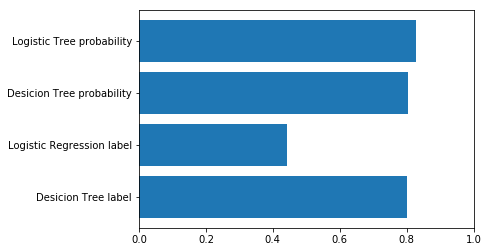

In [20]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(classifier_accuracy_comparisons)), list(classifier_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(classifier_accuracy_comparisons)), list(classifier_accuracy_comparisons.keys()))

## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

In [40]:
# Set up the parameter grid to search
param_grid = [
 {'criteria': ['probability','label'], 
  'base_models':[['LR','CART','NB'],['MLP','RF','SVC'],['MLP','CART','LR'],['RF', 'NB', 'KNN']], 
  'stack_model':['CART','LR'] ,
  'number_of_models':list(range(5, 11))
 }
]

# Perform the search
my_tuned_model = GridSearchCV(SuperLearnerClassifier(), param_grid, cv=cv_folds)
my_tuned_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print("Score for Best parameters set found on development set:")
print(my_tuned_model.best_score_)

Best parameters set found on development set:
{'base_models': ['RF', 'NB', 'KNN'], 'criteria': 'label', 'number_of_models': 5, 'stack_model': 'CART'}
Score for Best parameters set found on development set:
0.792380952381


Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [41]:
# Make a set of predictions for the hold out test data
y_pred = my_tuned_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None

print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8
             precision    recall  f1-score   support

          0       0.74      0.87      0.80        75
          1       0.99      0.87      0.92        92
          2       0.64      0.72      0.68       115
          3       0.81      0.74      0.77        91
          4       0.63      0.71      0.67        90
          5       0.89      0.95      0.92        87
          6       0.68      0.47      0.56        85
          7       0.88      0.87      0.88        87
          8       0.88      0.95      0.91        76
          9       0.94      0.88      0.91       102

avg / total       0.80      0.80      0.80       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,65,0,3,1,2,0,3,0,1,0,75
1,1,80,2,8,1,0,0,0,0,0,92
2,2,0,83,0,17,0,11,0,2,0,115
3,9,1,5,67,6,0,2,0,1,0,91
4,0,0,18,5,64,0,3,0,0,0,90
5,0,0,0,0,0,83,0,3,0,1,87
6,11,0,16,2,12,0,40,0,4,0,85
7,0,0,0,0,0,6,0,76,0,5,87
8,0,0,3,0,0,1,0,0,72,0,76


## Load test data 

In [29]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
test_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
test_X = test_dataset[test_dataset.columns[1:]]
test_Y = np.array(test_dataset["label"])

In [43]:
test_X = test_X/255 # normalize the test data

In [44]:
# Make a set of predictions for the test data
y_pred = my_tuned_model.predict(test_X)

# Print performance details
accuracy = metrics.accuracy_score(test_Y, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_Y, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(test_Y), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.817
             precision    recall  f1-score   support

          0       0.71      0.80      0.75      1000
          1       0.99      0.92      0.96      1000
          2       0.71      0.73      0.72      1000
          3       0.87      0.80      0.83      1000
          4       0.68      0.81      0.74      1000
          5       0.88      0.91      0.89      1000
          6       0.67      0.46      0.55      1000
          7       0.89      0.85      0.87      1000
          8       0.89      0.96      0.92      1000
          9       0.91      0.92      0.92      1000

avg / total       0.82      0.82      0.81     10000

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,804,0,22,50,13,2,75,1,33,0,1000
1,19,921,16,27,0,0,11,0,6,0,1000
2,18,0,735,4,163,0,57,0,23,0,1000
3,78,6,39,797,59,0,18,0,3,0,1000
4,7,0,99,14,813,1,60,0,6,0,1000
5,4,0,0,0,1,905,0,58,4,28,1000
6,197,0,119,26,149,2,462,0,45,0,1000
7,0,0,0,0,0,87,0,849,0,64,1000
8,3,1,11,3,5,5,3,7,961,1,1000


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

In [57]:
classifier_accuracy_comparisons = dict()
# train the Super learner without the descriptive feature
params = {'base_models': ['RF', 'NB', 'KNN'], 'criteria': 'label', 'number_of_models': 5, 'stack_model': 'CART'} # best_params from GridSearchCV
clf = SuperLearnerClassifier(**params)
clf.fit(X_train, y_train)
y_pred_without_desc_feature = clf.predict(X_test)

# train the Super learner with the descriptive feature
clf_desc_feature = SuperLearnerClassifier(stack_input=True, **params)
clf_desc_feature.fit(X_train, y_train)
y_pred_desc_feature = clf_desc_feature.predict(X_test)

# measure accuracy of the model trained without descriptive feature
accuracy = metrics.accuracy_score(y_test, y_pred_without_desc_feature) 
classifier_accuracy_comparisons['without_descriptive_feature'] = accuracy

# measure accuracy of the model trained with the descriptive feature
accuracy = metrics.accuracy_score(y_test, y_pred_desc_feature)
classifier_accuracy_comparisons['with_descriptive_feature'] = accuracy

# Print performance details
display(classifier_accuracy_comparisons)


{'with_descriptive_feature': 0.76888888888888884,
 'without_descriptive_feature': 0.79333333333333333}

Adding original feature should have increased the performance. However, here there is a slight decresase. 
This is probably due the reason that, MNIST data set has many descriptive features and the sample dataset 
we are using is not enough with respect to the number of features available in the trainig set.
Thus, because of curse of dimensionality the accuracy is slightly decreased.

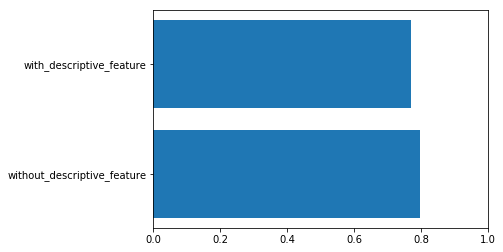

In [56]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(classifier_accuracy_comparisons)), list(classifier_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(classifier_accuracy_comparisons)), list(classifier_accuracy_comparisons.keys()))

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

Create and fit the super learner with all possible base learners to investigate the correlation

In [295]:
# create a SuperLearner object to check the diversity of the base_learners
clf = SuperLearnerClassifier( base_models=['LR','KNN','CART','SVC','NB','RF','MLP'], number_of_models=7)

#fit the model using x_train and y_train
clf.fit(X_train,y_train)


SuperLearnerClassifier(base_models=['LR', 'KNN', 'CART', 'SVC', 'NB', 'RF', 'MLP'],
            criteria='label', number_of_models=7, stack_input=False,
            stack_model='CART')

<font color='red' style='font-style:italic'>Diversity measures of the base models</font>

In [291]:
#get the diversity measure
corr_coeff , q_stat, disagreement_measure = clf.get_diversity_base_models()

In [272]:
#corr_coeff
round(corr_coeff,2)

,LR,KNN,CART,SVC,NB,RF,MLP
LR,1.00,0.51,0.44,0.60,0.31,0.60,0.55
KNN,0.51,1.00,0.40,0.53,0.28,0.60,0.44
CART,0.44,0.40,1.00,0.48,0.29,0.50,0.34
SVC,0.60,0.53,0.48,1.00,0.35,0.79,0.45
NB,0.31,0.28,0.29,0.35,1.00,0.35,0.26
RF,0.60,0.60,0.50,0.79,0.35,1.00,0.44
MLP,0.55,0.44,0.34,0.45,0.26,0.44,1.00


High value means high correlation 

In [ ]:
#q_statistics
round(q_stat,2)

High value means high correlation 

In [301]:
#disagreement_measure
round(disagreement_measure,2)

,LR,KNN,CART,SVC,NB,RF,MLP
LR,0.00,0.17,0.23,0.15,0.34,0.13,0.15
KNN,0.17,0.00,0.25,0.18,0.35,0.15,0.21
CART,0.23,0.25,0.00,0.22,0.35,0.20,0.27
SVC,0.15,0.18,0.22,0.00,0.32,0.08,0.21
NB,0.34,0.35,0.35,0.32,0.00,0.32,0.36
RF,0.13,0.15,0.20,0.08,0.32,0.00,0.20
MLP,0.15,0.21,0.27,0.21,0.36,0.20,0.00


High value means high Disagreement. That means low values indict high level of correlation.

<font color='red' style='font-style:italic'>Predictive power of the base models</font>

Accuracy measures

In [304]:
print('Accuracies of the base models')
clf.get_predictive_power_base_models()

Accuracies of the base models


{'CART': 0.68533333333333335,
 'KNN': 0.75600000000000001,
 'LR': 0.79933333333333334,
 'MLP': 0.78666666666666663,
 'NB': 0.55600000000000005,
 'RF': 0.78133333333333332,
 'SVC': 0.74333333333333329}

Confusion matrix

In [300]:
cf = clf.get_confusion_matrix_base_models()
for model in cf:
    print('--------------------------------'+str(model)+'---------------------------------------')
    print('\n')
    print(cf[model])
    print('\n')

--------------------------------LR---------------------------------------


Predicted    0    1    2    3    4    5    6    7    8    9   All
True                                                             
0          115    2    3   12    1    0   11    0    2    0   146
1            0  130    2    5    2    0    0    0    0    0   139
2            2    0  119    2   26    0   13    0    4    0   166
3            4    3    1  128    6    0    9    0    0    0   151
4            1    0   20   11  129    0    9    0    3    0   173
5            0    0    0    0    0  113    0   16    2   10   141
6           25    0   22   10   22    0   62    0    7    0   148
7            0    0    0    0    0    8    0  112    0    7   127
8            0    0    2    2    3    0    1    1  145    0   154
9            0    0    0    1    0    1    0    5    2  146   155
All        147  135  169  171  189  122  105  134  165  163  1500


--------------------------------KNN-----------------------------